In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import copy
import scipy.stats as st
import heapq
import pandas as pd
from collections import deque
from numpy.ma.core import zeros



In [ ]:
#class to generate lanes and estimate their parameters for when new cars arrive
import numpy as np
import matplotlib.pyplot as plt


class Lane:

    def __init__(self, n, times, b):
        self.n = n
        self.times = times
        self.b = b
        self.len = np.alen(times)
        self.deltas = np.zeros(self.len)
        self.deltas[0] = times[0]
        self.deltas[1:] = times[1:] - times[:-1]
        self.offDeltas = self.deltas - b
        self.alpha = 1 - np.mean(self.offDeltas == 0)
        muSamples = 20
        muPoints = np.zeros(muSamples)
        for i in range(np.alen(muPoints)):
            t = (i + 1) * (np.amax(self.deltas) / 2) / np.alen(muPoints)
            muPoints[i] = np.log(-self.alpha / (np.mean(self.offDeltas <= t) - 1)) / t
        self.mu = np.mean(muPoints)
        self.muSTD = np.std(muPoints)
        self.muCI = 1.96 * self.muSTD / np.sqrt(muSamples)

    def testAlphaMu(self):
        plt_points = 100
        sim_input = np.linspace(0, np.amax(self.offDeltas), plt_points)
        sim_dist = 1 - self.alpha * np.exp(-self.mu * sim_input)
        plt.hist(self.offDeltas, bins=plt_points, label='samples', cumulative=True,
                 weights=[1 / self.len] * self.len)
        plt.plot(sim_input, sim_dist, alpha=0.8, label='simulated', linewidth=4)
        plt.title('Comparison of samples with simulated alpha and mu for lane ' + str(self.n))
        plt.legend()
        plt.show()

    def printAlphaMu(self):
        out = 'For lane ' + str(self.n) + ', alpha = ' + str(self.alpha) + ' and mu = ' + str(self.mu) + '±' + str(self.muCI)
        print(out)



In [ ]:
rng = np.random.default_rng()

#import the given arrivals document
#timeLst = pd.read_csv('arrivals22.csv', sep = ';', header = None).to_numpy()
timeLst = pd.read_excel('arrivals22.xlsx', header = None).to_numpy()
#timeLst = np.array([[1,2.3],[2,3.3],[4.8,3.5],[9.2,5.2],[30,7.0],[31,8.1],[32,10.0]])
print(timeLst)
nCarPerLane, lanes = np.shape(timeLst)
b = 1
s = 2.4
laneLst = []
alphaLst = np.zeros(lanes)
muLst = np.zeros(lanes)
for n in range(lanes):
    laneLst.append(Lane(n, timeLst[:,n], b))
    laneLst[n].printAlphaMu()
    laneLst[n].testAlphaMu()
    alphaLst[n] = laneLst[n].alpha
    muLst[n] = laneLst[n].mu

In [ ]:
class Car:

    def __init__(self, arrTime, lane):
        self.arrTime = arrTime
        self.lane = lane

    def setDepTime(self, depTime):
        self.depTime = depTime

In [ ]:
class Event:

    ARRIVAL = 0
    DEPARTURE = 1

    def __init__(self, typ, car):
        self.type = typ
        self.car = car
        if self.type == self.ARRIVAL:
            self.time = self.car.arrTime
        elif self.type == self.DEPARTURE:
            self.time = self.car.depTime

    def __lt__(self, other):
        return self.time < other.time

In [ ]:
class FES:

    def __init__(self):
        self.events = []

    def add(self, event):
        heapq.heappush(self.events, event)

    def next(self):
        return heapq.heappop(self.events)

    def isEmpty(self):
        return len(self.events) == 0

    def getNumberOfEvents(self):
        return len(self.events)

In [ ]:
class SimResults:
  MAX_QL = 10000 # maximum queue length that will be recorded
  def __init__(self):
    self.sumQL = 0
    self.sumQL2 = 0
    self.oldTime = 0
    self.queueLengthHistogram = zeros(self.MAX_QL + 1)
    self.sumW = 0
    self.sumW2 = 0
    self.nW = 0
    self.waitingTimes = deque()

  def registerQueueLength(self, time, ql):
    self.sumQL += ql * (time - self.oldTime)
    self.sumQL2 += ql * ql * (time - self.oldTime)
    self.queueLengthHistogram[min(ql, self.MAX_QL)] += (time - self.oldTime)
    self.oldTime = time

  def registerWaitingTime(self, w):
    self.waitingTimes.append(w)
    self.nW += 1
    self.sumW += w
    self.sumW2 += w * w

  def getMeanQueueLength(self):
    return self.sumQL / self.oldTime
  def getVarianceQueueLength(self):
    return self.sumQL2 / self.oldTime - self.getMeanQueueLength()**2

  def getMeanWaitingTime(self):
    return self.sumW / self.nW 
  def getVarianceWaitingTime(self):
    return self.sumW2 / self.nW - self.getMeanWaitingTime()**2

  def getQueueLengthHistogram(self) :
    return [x/self.oldTime for x in self.queueLengthHistogram]
  def getWaitingTimes(self):
    return self.waitingTimes

  def getConfidenceInterval(self):
    return (st.t.interval(confidence=0.95, df=len(self.waitingTimes)-1, loc=np.mean(self.waitingTimes), scale=st.sem(self.waitingTimes)))

  def __str__(self):
    s = 'Mean queue length: '+str(self.getMeanQueueLength()) + '\n'
    s += 'Variance queue length: '+str(self.getVarianceQueueLength()) + '\n'
    s += 'Mean waiting time: '+str(self.getMeanWaitingTime()) + '\n'
    s += 'Variance waiting time: '+str(self.getVarianceWaitingTime()) + '\n'
    s += 'Confidence Interval for the waiting time is' +str(self.getConfidenceInterval()) +'\n'
    return s 

  def histQueueLength(self, maxq=50):
    ql = self.getQueueLengthHistogram()
    maxx = maxq + 1 
    plt.figure()
    plt.bar(range(0, maxx), ql[0:maxx])
    plt.ylabel('P(Q = k)')
    plt.xlabel('k')
    plt.title('Histogram of the queue length using FCFS')
    plt.grid()
    plt.show()

  def histWaitingTimes(self, nrBins=100): 
    plt.figure()
    plt.hist(self.waitingTimes, bins=nrBins, rwidth=0.8, density=True) 
    plt.title('Histogram of waiting times using FCFS')
    plt.grid()
    plt.show()


In [ ]:
import numpy as np
from collections import deque

rng = np.random.default_rng()

class FCFSSimulation:

    def __init__(self, lanes, alphaLst, muLst, b, s, vm, x0):
        self.lanes = lanes
        self.alphaLst = alphaLst
        self.muLst = muLst
        self.b = b
        self.s = s
        self.minT = x0 / vm
        self.nrCars = 0

    def simulate(self, totalCars):
        laneQueue = [] #Queues for each lane
        table = np.zeros((totalCars, 3))
        res = []
        crossingQueue = deque() #Queue for all lanes at crossing
        previousDepartureTime = 0

        for lane in range(self.lanes):
          laneRes = SimResults () # simulation results
          res.append(laneRes)
          laneQueue.append(deque())

        t = 0
        fes = FES()
        firstCarArrTime = 1000 #set random high number 
        for lane in range(self.lanes):
            arrTime = t + self.b + rng.exponential(scale = 1/self.muLst[lane]) * self.alphaLst[lane]
            car = Car(arrTime, lane)
            arr = Event(Event.ARRIVAL, car)
            fes.add(arr)
            if arrTime < firstCarArrTime : #get first lane car moves from
                firstCarArrTime = arrTime
                currentLane = lane
            

        while self.nrCars < totalCars:
            e = fes.next()
            t = e.time
            lane = e.car.lane
            
            for l in range(self.lanes):
                res[l].registerQueueLength(t, len(laneQueue[l])) #register queue lengths for all lanes

            if e.type == Event.ARRIVAL:
                oldCar = e.car
                laneQueue[lane].append(oldCar)
                crossingQueue.append(oldCar)
                if len(crossingQueue) == 1: #only one lane can have cars moving so there is only 1 server 
                    #if there is a free server, 
                    res[lane].registerWaitingTime(t - oldCar.arrTime) #register car waiting time when car departs , if q is 0 waiting time shd be 0
                    if oldCar.lane == currentLane :
                        if oldCar.arrTime - previousDepartureTime <1: #if moving from same lane, time must be more than or equal to 1
                            depTime = previousDepartureTime +1
                        else:
                            depTime = t 
                        car.setDepTime(depTime)
                        dep =Event(Event.DEPARTURE, oldCar) 
                        previousDepartureTime = t 
                    else:
                        if oldCar.arrTime - previousDepartureTime <2.4: #if moving from a different lane, time must be more than or equal to 2.4
                            depTime = previousDepartureTime +2.4
                        else:
                            depTime = t 
                        oldCar.setDepTime(depTime)
                        dep =Event(Event.DEPARTURE, oldCar)  
                        previousDepartureTime = depTime 
                        currentLane =  oldCar.lane
                    fes.add(dep)

                if len(crossingQueue) != 0:
                    arrTime = t + rng.exponential(scale=1 / self.muLst[lane]) * self.alphaLst[lane]
                    car = Car(arrTime, lane)
                    arr = Event(Event.ARRIVAL, car)
                    fes.add(arr)

            elif e.type == Event.DEPARTURE:
                
                previousDepartureTime = t 
                oldCar = e.car
                laneQueue[oldCar.lane].remove(oldCar)
                crossingQueue.remove(oldCar)
                res[oldCar.lane].registerWaitingTime(t - oldCar.arrTime) #car has moved off, so register its waiting time and remove it from queue

                table[self.nrCars, 0] = oldCar.lane
                table[self.nrCars, 1] = oldCar.arrTime
                table[self.nrCars, 2] = oldCar.depTime
                self.nrCars += 1

                if len(crossingQueue) > 0:
                    car = crossingQueue[0] 
                    
                    if car.lane == currentLane:
                        depTime = previousDepartureTime+self.b
                    else:
                        depTime = previousDepartureTime+self.s                
                    car.setDepTime(depTime)

                    dep = Event(Event.DEPARTURE, car) 
                    fes.add(dep)
                    currentLane = car.lane
                    previousDepartureTime = t

        return table , res

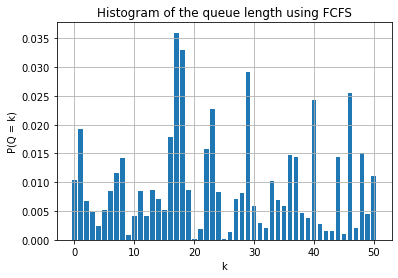

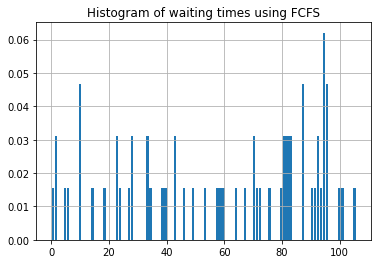

Mean queue length: 48.382859392451785
Variance queue length: 683.0017792397175
Mean waiting time: 58.53836337501076
Variance waiting time: 1049.57263809812
Confidence Interval for the waiting time is(50.17222031222286, 66.90450643779864)



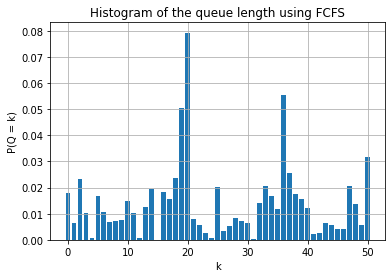

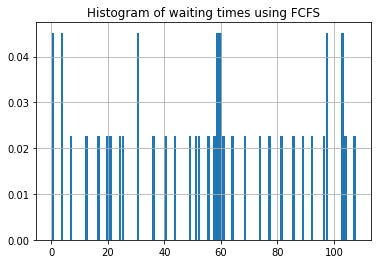

Mean queue length: 35.77595741287902
Variance queue length: 434.8745802992694
Mean waiting time: 54.2071305102876
Variance waiting time: 1059.6896443847663
Confidence Interval for the waiting time is(43.80453140933117, 64.60972961124402)



In [ ]:
vm = 13
x0 = 300
sim = FCFSSimulation(lanes, alphaLst, muLst, b, s, vm, x0)
table , results = sim.simulate(100)
_, counts = np.unique(table[:, 0], return_counts = True)
carLstOut = np.zeros((max(counts), 2 * lanes))
for n in range(lanes):
    laneArray = table[table[:, 0] == n]
    laneArray = np.pad(laneArray, ((0, max(counts) - counts[n]), (0, 0)), 'constant', constant_values=0)
    carLstOut[:, 2 * n] = laneArray[:, 1]
    carLstOut[:, 1 + 2 * n] = laneArray[:, 2]

for lane in range(lanes):
    results[lane].histQueueLength() # plot of the queue length
    results[lane].histWaitingTimes() # histogram of waiting times
    print(str(results[lane])) #confidence interval of waiting times

In [ ]:

import numpy as np
from collections import deque

rng = np.random.default_rng()

class CyclicSimulation:

    def __init__(self, lanes, alphaLst, muLst, b, s, vm, x0):
        self.lanes = lanes
        self.alphaLst = alphaLst
        self.muLst = muLst
        self.b = b
        self.s = s
        self.minT = x0 / vm
        self.nrCars = 0

    def simulate(self, totalCars):
        queue = [deque()] * self.lanes
        table = np.zeros((totalCars, 3))
        res = []
        z = 0
        t = 0
        currentLane = 0
        fes = [[]] * (self.lanes + 1)
        fes[self.lanes] = FES()
        #create FES for each lane
        for lane in range(self.lanes):
            res.append(SimResults()) #simulation results
            fes[lane] = FES()
            arrTime = t + self.b + rng.exponential(scale = 1/self.muLst[lane]) * self.alphaLst[lane]
            car = Car(arrTime, lane)
            arr = Event(Event.ARRIVAL, car)
            fes[self.lanes].add(arr)

        while self.nrCars < totalCars:
            for l in range(self.lanes):
                res[l].registerQueueLength(t, len(queue[l])) #register queue lengths for all lanes

            prevLane = currentLane
            notAllEmpty = 0
            for lane in range(self.lanes):
                #check which lane is empty
                notAllEmpty += not fes[lane].isEmpty()
            if fes[currentLane].isEmpty() and bool(notAllEmpty):
                #if current lane is empty and there are cars in other lanes, change to other lanes
                while fes[currentLane].isEmpty(): 
                    currentLane += (currentLane + 1) % self.lanes
                    if prevLane == currentLane:
                        break
                    #if all lanes are empty return to inital current lane
                car = queue[currentLane][0]#get first car in lane
                depTime = max(t + self.s, car.arrTime + self.minT) #add departure event of car
                car.setDepTime(depTime)
                dep = Event(Event.DEPARTURE, car)
                fes[currentLane].add(dep)
                oldCar = car
                if len(queue[currentLane]) > 1: #if there are more cars in the lane schedhule departure events of all teh cars
                    for carEntry in range(1, len(queue[currentLane])):
                        car = queue[currentLane][carEntry]
                        depTime = max(oldCar.depTime + self.b, car.arrTime + self.minT)
                        car.setDepTime(depTime)
                        dep = Event(Event.DEPARTURE, car)
                        fes[currentLane].add(dep)
                        oldCar = car

            if not bool(notAllEmpty) or fes[self.lanes].events[0].time < fes[currentLane].events[0].time:
                # if there are no cars or there are events that occur before the current lane, 
                e = fes[self.lanes].next()
                t = e.time
                car = e.car
                lane = car.lane
                queue[lane].append(car)
                if lane == currentLane and len(queue[lane]) == 1:
                    #if same lane and there is only one car, schedhule departure of the car
                    depTime = t + self.minT
                    car.setDepTime(depTime)
                    dep = Event(Event.DEPARTURE, car)
                    fes[lane].add(dep)
                arrTime = t + self.b + rng.exponential(scale=1 / self.muLst[lane]) * self.alphaLst[lane]
                #create arrival of car
                car = Car(arrTime, lane)
                arr = Event(Event.ARRIVAL, car)
                fes[self.lanes].add(arr)

            else:
                e = fes[currentLane].next()
                t = e.time
                oldCar = e.car
                res[oldCar.lane].registerWaitingTime(t - oldCar.arrTime)
                queue[currentLane].remove(oldCar)
                table[self.nrCars, 0] = oldCar.lane
                table[self.nrCars, 1] = oldCar.arrTime
                table[self.nrCars, 2] = oldCar.depTime
                self.nrCars += 1

                if len(queue[currentLane]) > 0:
                    car = queue[currentLane][0]
                    waitTime = self.b
                    depTime = max((car.arrTime + self.minT), (oldCar.depTime + waitTime))
                    car.setDepTime(depTime)
                    dep = Event(Event.DEPARTURE, car)
                    fes[currentLane].add(dep)

        return table,res
        

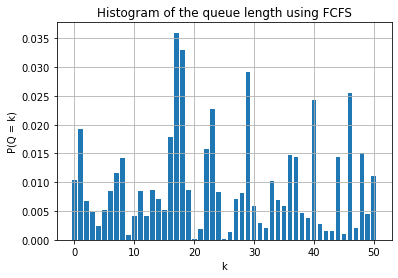

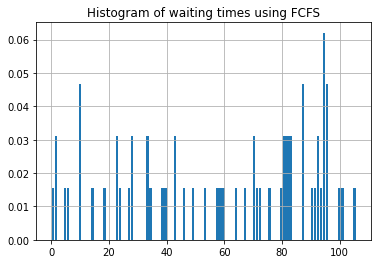

Mean queue length: 48.382859392451785
Variance queue length: 683.0017792397175
Mean waiting time: 58.53836337501076
Variance waiting time: 1049.57263809812
Confidence Interval for the waiting time is(50.17222031222286, 66.90450643779864)



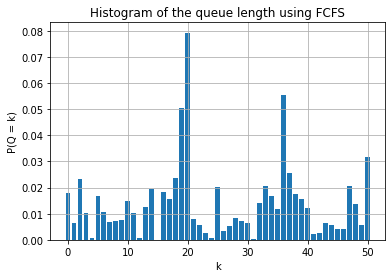

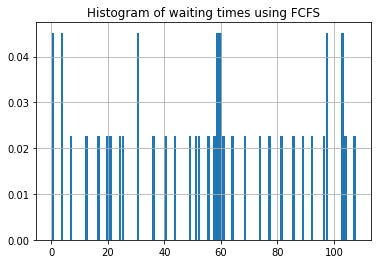

Mean queue length: 35.77595741287902
Variance queue length: 434.8745802992694
Mean waiting time: 54.2071305102876
Variance waiting time: 1059.6896443847663
Confidence Interval for the waiting time is(43.80453140933117, 64.60972961124402)



In [ ]:
vm = 13
x0 = 300
sim = CyclicSimulation(lanes, alphaLst, muLst, b, s, vm, x0)
table, res = sim.simulate(100)
_, counts = np.unique(table[:, 0], return_counts = True)
carLstOutC = np.zeros((max(counts), 2 * lanes))
for n in range(lanes):
    laneArray = table[table[:, 0] == n]
    laneArray = np.pad(laneArray, ((0, max(counts) - counts[n]), (0, 0)), 'constant', constant_values=0)
    carLstOutC[:, 2 * n] = laneArray[:, 1]
    carLstOutC[:, 1 + 2 * n] = laneArray[:, 2]

for lane in range(lanes):
    results[lane].histQueueLength() # plot of the queue length
    results[lane].histWaitingTimes() # histogram of waiting times
    print(str(results[lane])) #confidence interval of waiting times

<ipython-input-49-5b7a420d047e>:26: RuntimeWarning: invalid value encountered in sqrt
  self.dTAcc = np.sqrt((self.delta * self.vm - x0) / self.am)


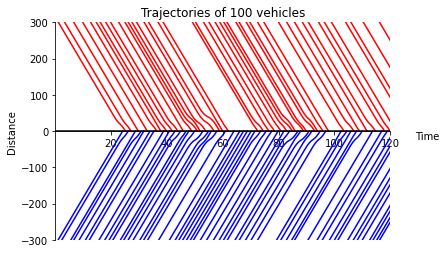

In [ ]:
#class to create cars and output their trajectory when asked, see below for creating and outputing an example
import numpy as np


class CarTrajectory:

    def __init__(self, arr, dep, am, vm, x0, stopDist = 13, prevCarXFullEnd = None):
        self.arr = arr
        self.dep = dep
        self.am = am
        self.vm = vm
        self.x0 = x0
        self.delta = dep - arr

        self.dTAcc = vm / am # assuming full stop of dt = 0
        self.xAcc = 1/2 * self.vm ** 2 / self.am
        self.dTFull = self.delta - 2 * self.dTAcc
        self.xFull = self.dTFull * vm
        if (self.xFull + 2 * self.xAcc) > self.x0:
            self.xFull = self.x0 - 2 * self.xAcc
            self.dTFull = self.xFull / self.vm
            self.dTStop = self.delta - self.dTFull - 2 * self.dTAcc
        else:
            self.dTStop = 0
            if (self.xFull + 2 * self.xAcc) < self.x0:
                self.dTAcc = np.sqrt((self.delta * self.vm - x0) / self.am)
                self.xAcc = -1/2 * self.am * self.dTAcc ** 2 + self.vm * self.dTAcc
                self.dTFull = self.delta - 2 * self.dTAcc
                self.xFull = self.dTFull * self.vm
        if prevCarXFullEnd != None:
            self.xFullEnd = prevCarXFullEnd + stopDist
            self.dTFullEnd = self.xFullEnd / self.vm
            self.xFullStart = self.xFull - self.xFullEnd
            self.dTFullStart = self.dTFull - self.dTFullEnd
        else:
            self.xFullEnd = 0
            self.dTFullEnd = 0
            self.xFullStart = self.xFull
            self.dTFullStart = self.dTFull


    def trajectory(self, stepSize):
        timePoints = np.linspace(self.arr, self.dep, int(np.ceil(self.delta/stepSize)) + 1)
        xPoints = np.zeros(np.alen(timePoints))
        dTimePoints = timePoints - self.arr
        for i in range(np.alen(timePoints)):
            if dTimePoints[i] <= self.dTFullStart:
                xPoints[i] = - self.x0 + dTimePoints[i] * self.vm
            elif dTimePoints[i] <= (self.dTFullStart + self.dTAcc):
                subT = dTimePoints[i] - self.dTFullStart
                xPoints[i] = - self.x0 + self.xFullStart + self.vm * subT - 1/2 * self.am * subT ** 2
            elif dTimePoints[i] <= (self.dTFullStart + self.dTAcc + self.dTStop):
                xPoints[i] = - self.xFullEnd - self.xAcc
            elif dTimePoints[i] <= (self.dTFullStart + 2 * self.dTAcc + self.dTStop):
                subT = dTimePoints[i] - self.dTFullStart - 2 * self.dTAcc - self.dTStop
                xPoints[i] = - self.xFullEnd + self.vm * subT + 1/2 * self.am * subT ** 2
            else:
                xPoints[i] = (timePoints[i] - self.dep) * self.vm
        return timePoints, xPoints

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import from csv assuming the datastructure is arrival time lane 0; departure time lane 0; arr t l1, dep t l1, etc assumed for each lane to have its cars chronologically ordered
#carLst = pd.read_csv('cars22.csv', sep = ';', header = None).to_numpy() #Example
#carLst = carLstOut    #array FCFS
carLst = carLstOutC    #array CES

#setting variables according to assignment
nCarPerLane, lanes = np.shape(carLst)
lanes = int(lanes / 2)
am = 3
vm = 13
x0 = 300
b = 1
minT = x0 / vm
stopDist = b * vm
prevCar = CarTrajectory(-minT, 0, am, vm, x0)

#plot settings
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Distance')
ax.set_xlabel('Time')
ax.xaxis.set_label_coords(1.11, 0.5)

for i in range(lanes):
    for n in range(nCarPerLane):
        if n > 0 and carLst[n, 2 * i] < (prevCar.dep - minT): # pass data on previous car if too close
            car = CarTrajectory(carLst[n, 2 * i], carLst[n, 1 + 2 * i], am, vm, x0, stopDist, prevCar.xFullEnd)
        else:
            car = CarTrajectory(carLst[n, 2 * i], carLst[n, 1 + 2 * i], am, vm, x0)
        prevCar = car
        #get time and trajectory output for specific car at roughly 0.5s intervals (makes them shorter if nessecary to also fit both the start and end point)
        time, distance = car.trajectory(0.5)
        #generate plot line from trajectory for said car
        if i == 1:
            distance = distance * -1
            clr = 'r'
        else:
            clr = 'b'
        plt.plot(time, distance, color=clr)

#more plot settings
plt.title('Trajectories of 100 vehicles')
plt.axis([0.1, 120, -300, 300])
plt.axhline(0, color='k')
plt.show()